In [31]:
import pandas as pd
import numpy as np
import prince

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [2]:
marketing = pd.read_csv("marketing_campaign.csv", encoding="utf-8", sep= "\t")

## Pré traitement des données

In [3]:
marketing.drop(['Z_CostContact','Z_Revenue'], axis=1, inplace=True)

In [4]:
marketing.fillna({'Income': marketing['Income'].median()}, inplace=True)

In [5]:
marketing['Education'] = marketing['Education'].astype('category')
marketing['Marital_Status'] = marketing['Marital_Status'].astype('category')
marketing['Kidhome'] = marketing['Kidhome'].astype('category')
marketing['Teenhome'] = marketing['Teenhome'].astype('category')
marketing['Dt_Customer'] = pd.to_datetime(marketing['Dt_Customer'], format='%d-%m-%Y')

In [6]:
marketing['AcceptedCmp1'] = marketing['AcceptedCmp1'].astype('category')
marketing['AcceptedCmp1'] = marketing['AcceptedCmp1'].cat.rename_categories({0: 'No', 1:'Yes'})
marketing['AcceptedCmp2'] = marketing['AcceptedCmp2'].astype('category')
marketing['AcceptedCmp2'] = marketing['AcceptedCmp2'].cat.rename_categories({0: 'No', 1:'Yes'})
marketing['AcceptedCmp3'] = marketing['AcceptedCmp3'].astype('category')
marketing['AcceptedCmp3'] = marketing['AcceptedCmp3'].cat.rename_categories({0: 'No', 1:'Yes'})
marketing['AcceptedCmp4'] = marketing['AcceptedCmp4'].astype('category')
marketing['AcceptedCmp4'] = marketing['AcceptedCmp4'].cat.rename_categories({0: 'No', 1:'Yes'})
marketing['AcceptedCmp5'] = marketing['AcceptedCmp5'].astype('category')
marketing['AcceptedCmp5'] = marketing['AcceptedCmp5'].cat.rename_categories({0: 'No', 1:'Yes'})
marketing['Complain'] = marketing['Complain'].astype('category')
marketing['Complain'] = marketing['Complain'].cat.rename_categories({0: 'No', 1:'Yes'})
marketing['Response'] = marketing['Response'].astype('category')
marketing['Response'] = marketing['Response'].cat.rename_categories({0: 'No', 1:'Yes'})

In [7]:
marketing = marketing.drop(marketing[marketing['ID'] == 9432].index)

In [8]:
vieux = marketing.loc[marketing['Year_Birth'] < 1920, 'ID']
for i in vieux: 
    marketing = marketing.drop(marketing[marketing['ID'] == i].index)

In [9]:
marketing["Age_Categorie"] = pd.cut(
    2015 - marketing["Year_Birth"],
    bins=[18, 30, 45, 60, float('inf')],
    labels=["Age_18-30", "Age_30-45", "Age_45-60", "Age_>60"],
    right=True
)

In [10]:
viandards = marketing.loc[marketing['MntMeatProducts'] > 1500, 'ID']
for i in viandards: 
    marketing = marketing.drop(marketing[marketing['ID'] == i].index)

In [11]:
gourmands = marketing.loc[marketing['MntSweetProducts'] > 225, 'ID']
for i in gourmands: 
    marketing = marketing.drop(marketing[marketing['ID'] == i].index)

In [12]:
marketing['Depense_Total']= marketing[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum(axis=1)
marketing['Total_Achat'] = marketing[['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].sum(axis=1)

In [13]:
date_reference = pd.to_datetime('2015-01-01')

marketing['Anciennete_jours'] = (date_reference - marketing['Dt_Customer']).dt.days

marketing['Anciennete_mois'] = (marketing['Anciennete_jours'] / 30.44).round(1)

In [14]:
marketing['Marital_Status'] = marketing['Marital_Status'].replace({
    'YOLO': None,
    'Absurd': None,
    'Married': 'Couple',
    'Together': 'Couple',
    'Single': 'Seul',
    'Alone': 'Seul',
    'Widow': 'Seul',
    'Divorced': 'Divorcé'
})

/tmp/ipykernel_1823/2065117912.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  marketing['Marital_Status'] = marketing['Marital_Status'].replace({


In [16]:
marketing['Total_Enfants'] = marketing['Kidhome'].astype(int) + marketing['Teenhome'].astype(int)
marketing['Total_Enfants'] = marketing['Total_Enfants'].astype('category')
marketing.drop(['Kidhome', 'Teenhome'], axis=1, inplace=True)

In [18]:
marketing['Niveau_Etude'] = marketing['Education'].replace({
    'Graduation': 'Moyen',
    'PhD': 'Eleve',
    'Master': 'Eleve',
    '2n Cycle': 'Faible',
    'Basic': 'Moyen',
})
marketing.drop(['Education'], axis=1, inplace=True)

/tmp/ipykernel_1823/501913221.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  marketing['Niveau_Etude'] = marketing['Education'].replace({


In [19]:
marketing['Nbr_Cmp'] = marketing[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']].apply(lambda x: x.cat.codes).sum(axis=1)

In [20]:
marketing.head()

,ID,Year_Birth,Marital_Status,Income,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Complain,Response,Age_Categorie,Depense_Total,Total_Achat,Anciennete_jours,Anciennete_mois,Total_Enfants,Niveau_Etude,Nbr_Cmp
0,5524,1957,Seul,58138.0,2012-09-04,58,635,88,546,172,...,No,Yes,Age_45-60,1617,22,849,27.9,0,Moyen,1
1,2174,1954,Seul,46344.0,2014-03-08,38,11,1,6,2,...,No,No,Age_>60,27,4,299,9.8,2,Moyen,0
2,4141,1965,Couple,71613.0,2013-08-21,26,426,49,127,111,...,No,No,Age_45-60,776,20,498,16.4,0,Moyen,0
3,6182,1984,Couple,26646.0,2014-02-10,26,11,4,20,10,...,No,No,Age_30-45,53,6,325,10.7,1,Moyen,0
4,5324,1981,Couple,58293.0,2014-01-19,94,173,43,118,46,...,No,No,Age_30-45,422,14,347,11.4,1,Eleve,0


In [22]:
marketing.columns

Index(['ID', 'Year_Birth', 'Marital_Status', 'Income', 'Dt_Customer',
       'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Response', 'Age_Categorie', 'Depense_Total', 'Total_Achat',
       'Anciennete_jours', 'Anciennete_mois', 'Total_Enfants', 'Niveau_Etude',
       'Nbr_Cmp'],
      dtype='object')

## Application de la NMF

In [58]:
# on garde que les variables quanti (et positives mais ici elles l'étaient dèjà toutes). On fait aussi un peu le tri pour
# ne pas avoir de variables redondantes.

features_nmf = [
    'Income', 'Recency',
    'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
    'NumStorePurchases', 'NumWebVisitsMonth', 'Depense_Total',
    'Total_Achat', 'Anciennete_mois', 'Nbr_Cmp'
]

In [59]:
# on normalise les données

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(marketing[features_nmf])

In [62]:
# on applique la NMF

from sklearn.decomposition import NMF

# on choisit arbitrairement un nombre de composants pour commencer

nmf = NMF(n_components=3, random_state=0)
W = nmf.fit_transform(X_scaled)  # Matrice des clients x composantes
H = nmf.components_              # Matrice des composantes x variables

In [63]:
components = pd.DataFrame(H, columns=features_nmf)
components.T.sort_values(by=0, ascending=False)

,0,1,2
NumStorePurchases,4.869077,0.887985,0.745030
Total_Achat,4.679492,0.735298,0.477357
NumCatalogPurchases,4.242505,0.000000,0.000000
Depense_Total,4.222689,0.000000,0.000000
Income,2.956889,0.479029,0.829643
NumWebPurchases,1.551795,0.548070,0.197656
Nbr_Cmp,1.513401,0.028719,0.000000
Anciennete_mois,1.098418,4.625136,0.000000
Recency,0.545892,0.000000,5.189003
NumDealsPurchases,0.322453,1.029279,0.333765


In [64]:
# On a ici une représentation des composantes latentes de la NMF. On a réduit nos données en 4 composantes latentes.
# On voit que le poids des achats et dépenses en tout genre est le plus fort dans la composante 0, avec la salaire en plus.
# On peut assimiler cette composante latente au pouvoir d'achat.
# La 1 est surtout influencée par l'ancienneté.
# La 2 par le nombre de jours depuis le dernier achat

In [65]:
# on peut faire un sorte de clustering sans vraiment en faire un. On va ajouter une variable à chaque client qui est sa
# composante dominante dans la NMF. Ainsi, on peut dresser des profils.

marketing['Profil_NMF'] = np.argmax(W, axis=1)

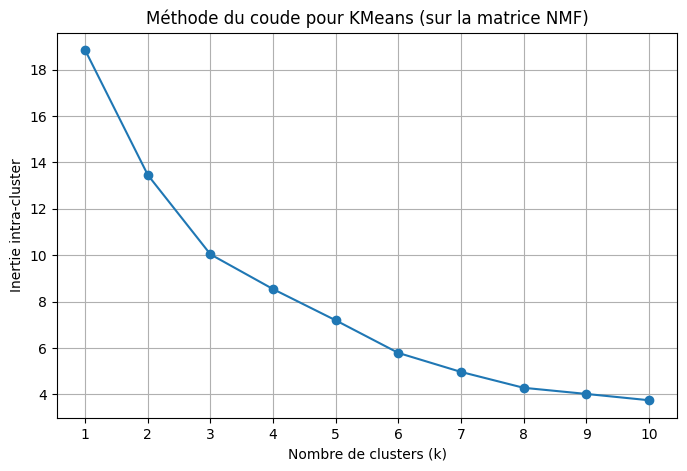

In [66]:
# on peut aussi effectuer un clustering sur la matrice W de la NMF. 

# on commence par une méthode du coude

inertias = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(W)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertias, marker='o')
plt.title("Méthode du coude pour KMeans (sur la matrice NMF)")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie intra-cluster")
plt.xticks(K_range)
plt.grid(True)
plt.show()

In [67]:
# on peut effectuer le k means dans notre matrice W des clients

kmeans = KMeans(n_clusters=3, random_state=0)
marketing['Cluster_NMF'] = kmeans.fit_predict(W)

# et on peut calculer la moyenne dans chaque cluster

marketing['Cluster_NMF'] = kmeans.labels_

cluster_profiles = marketing.groupby('Cluster_NMF')[features_nmf].mean()

print(cluster_profiles)

                   Income    Recency  NumDealsPurchases  NumWebPurchases  \
Cluster_NMF                                                                
0            44581.484453  75.837065           2.384328         3.440299   
1            65243.943135  38.816921           1.654646         4.624133   
2            46289.080256  29.274148           2.906250         4.241477   

             NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  \
Cluster_NMF                                                              
0                       1.553483           4.715174           5.907960   
1                       4.381415           7.368932           3.601942   
2                       2.046875           5.473011           6.451705   

             Depense_Total  Total_Achat  Anciennete_mois   Nbr_Cmp  
Cluster_NMF                                                         
0               361.776119     9.708955        17.380597  0.187811  
1               950.231623    16.374480  

In [69]:
# On voit que le cluster 0 est composé de gens ayant les revenus les plus bas, ayant ahceté le moins, qui ont visité le site
# il y a le plus longtemps.
# Le 1 sont les plus riches, qui achètent le plus, qui profitent moins des promotions, qui achètent beaucoup sur catalogue et en magasin,
# et qui visitent peu le site web, et qui sont les moins anciens.
# Le 3 sont ceux qui dépensent dans la moyenne, sans avoir forcément énormément plus de revenus que le cluster 0. Ils sont venus récemment 
# sur le site, et le visitent fréquemment. Surtout ce sont les plus anciens.

# On pourrait donc voir ces 3 clusters de la forme suivante :

# 1 - Moins fortunés, visites rares, et peu d'achats. -> Les frileux
# 2 - Plus fortunés, préference pour les achats en vrai, nouveaux clients -> Les chercheurs de qualité
# 3 - Pas très fortunés, mais visites fréquentes et les plus anciens -> Les habitués

# On peut ensuite proposer des promos ou communications personnalisés pour chaque cluster.